In [1]:
#!pip install tensorflow
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import scipy.io
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import clear_output
from scipy.signal import savgol_filter
import gc

**Loading the data and creating pickle file using only one batch**


In [2]:
def load_data(file_name,pickle_name,bn):
  f = h5py.File(file_name,"r")
  print(list(f.keys()))
  batch=f.get("batch")
  num_cells = batch['summary'].shape[0]
  bat_dict = {}
  for i in range(num_cells):
    cl = f[batch['cycle_life'][i,0]][()] #ici on a remplacé ".value" par "[()]", et dans toutes les lignes suivantes
    policy = f[batch['policy_readable'][i,0]][()].tobytes()[::2].decode()
    summary_IR = np.hstack(f[batch['summary'][i,0]]['IR'][0,:].tolist())
    summary_QC = np.hstack(f[batch['summary'][i,0]]['QCharge'][0,:].tolist())
    summary_QD = np.hstack(f[batch['summary'][i,0]]['QDischarge'][0,:].tolist())
    summary_TA = np.hstack(f[batch['summary'][i,0]]['Tavg'][0,:].tolist())
    summary_TM = np.hstack(f[batch['summary'][i,0]]['Tmin'][0,:].tolist())
    summary_TX = np.hstack(f[batch['summary'][i,0]]['Tmax'][0,:].tolist())
    summary_CT = np.hstack(f[batch['summary'][i,0]]['chargetime'][0,:].tolist())
    summary_CY = np.hstack(f[batch['summary'][i,0]]['cycle'][0,:].tolist())
    summary = ({'IR': summary_IR, #création d'un 1er dict avec les données "résumées", càd 1 donnée par cycle
               'QC': summary_QC, 
               'QD': summary_QD, 
               'Tavg': summary_TA, 
               'Tmin': summary_TM, 
               'Tmax': summary_TX, 
               'chargetime': summary_CT,
               'cycle': summary_CY}) 
    cycles = f[batch['cycles'][i,0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = np.hstack((f[cycles['I'][j,0]][()]))
        Qc = np.hstack((f[cycles['Qc'][j,0]][()]))
        Qd = np.hstack((f[cycles['Qd'][j,0]][()]))
        Qdlin = np.hstack((f[cycles['Qdlin'][j,0]][()]))
        T = np.hstack((f[cycles['T'][j,0]][()]))
        Tdlin = np.hstack((f[cycles['Tdlin'][j,0]][()]))
        V = np.hstack((f[cycles['V'][j,0]][()]))
        dQdV = np.hstack((f[cycles['discharge_dQdV'][j,0]][()]))
        t = np.hstack((f[cycles['t'][j,0]][()]))
        cd = ({'I': I,  
               'Qc': Qc, 
               'Qd': Qd, 
               'Qdlin': Qdlin, 
               'T': T, 
               'Tdlin': Tdlin, 
               'V':V, 
               'dQdV': dQdV, 
               't':t})
        cycle_dict[str(j)] = cd
        
    cell_dict = ({'cycle_life': cl, 
                 'charge_policy':policy, 
                  'summary': summary, 
                  'cycles': cycle_dict})
    key = "b"+bn+"c" + str(i)
    bat_dict[key]=   cell_dict


  df=pd.DataFrame(bat_dict)

  with open(pickle_name,'wb') as fp:
        pickle.dump(bat_dict,fp) 
  return df

In [ ]:
path_to_file="C:\\Users\\sarbaoui01\\Downloads\\"

In [4]:
b1=load_data(path_to_file+"2017-05-12_batchdata_updated_struct_errorcorrect.mat","batch1.pkl","1")
b2=load_data(path_to_file+"2017-06-30_batchdata_updated_struct_errorcorrect.mat","batch2.pkl","2")
b3=load_data(path_to_file+"2018-04-12_batchdata_updated_struct_errorcorrect.mat","batch3.pkl","3")

['#refs#', '#subsystem#', 'batch', 'batch_date']
['#refs#', '#subsystem#', 'batch', 'batch_date']
['#refs#', '#subsystem#', 'batch', 'batch_date']


In [2]:
batch1 = pickle.load(open(r'batch1.pkl', 'rb'))

In [3]:
numBat1 = len(batch1.keys())
numBat1

46

In [4]:
batch2 = pickle.load(open(r'batch2.pkl','rb'))
numBat2 = len(batch2.keys())

In [5]:
batch3 = pickle.load(open(r'batch3.pkl','rb'))
numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
numBat

140

In [6]:
bat_dict = {**batch1, **batch2, **batch3}

In [7]:
bat_dict_keys = bat_dict.keys()

In [8]:
bat_dict_keys

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c8', 'b1c9', 'b1c10', 'b1c11', 'b1c12', 'b1c13', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c22', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c7', 'b2c8', 'b2c9', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c15', 'b2c16', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47', 'b3c0', 'b3c1', 'b3c2', 'b3c3', 'b3c4', 'b3c5', 'b3c6', 'b3c7', 'b3c8', 'b3c9', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b

In [15]:
Ic=[]
Vc=[]
Tc=[]
Id=[]
Vd=[]
Td=[]
SOH=[]
qd=[]
charge_policy=[]
ce=[]
for i in bat_dict_keys:
    clear_output(wait=True)
    print('cell:', i)
    cell=bat_dict[i]
    num_cycle=len(cell['summary']['cycle'])
    for j in range(1,num_cycle):
        start_discharge = np.where(cell['cycles'][str(j)]['I'] < -0.05) 
        start_discharge = start_discharge[0][0]
        
        end_discharge = np.where(cell['cycles'][str(j)]['I'] < -3.9) 
        end_discharge = end_discharge[0][-1]
        
        start_charge = np.where(cell['cycles'][str(j)]['I'] > 0)
        end_charge = start_charge[0][-1]
        start_charge = start_charge[0][0]
        
        Id.append(cell['cycles'][str(j)]['I'][start_discharge:end_discharge])
        Vd.append(cell['cycles'][str(j)]['V'][start_discharge:end_discharge])
        Td.append(cell['cycles'][str(j)]['T'][start_discharge:end_discharge])
        
        Ic.append(cell['cycles'][str(j)]['I'][start_charge:end_charge])
        Vc.append(cell['cycles'][str(j)]['V'][start_charge:end_charge])
        Tc.append(cell['cycles'][str(j)]['T'][start_charge:end_charge])
        charge_policy.append(cell['charge_policy'])  
        
        QC = cell['summary']['QC'][j]
        QD = cell['summary']['QD'][j]
        qd.append(QD)
        initial_Qd=cell['summary']['QD'][1]
        SOH.append((QD)/initial_Qd)
        dict_key = "{}_cycle_{}".format(i,j)
        ce.append(dict_key)
print('all cycles from batches 1, 2 and 3 were browsed')

cell: b3c45
all cycles from batches 1, 2 and 3 were browsed


In [16]:
df=pd.DataFrame({"Ic":Ic,"Id":Id,"Vc":Vc,"Vd":Vd,"Tc":Tc,"Td":Td,"charge_policy":charge_policy,"SOH":SOH,"QD":qd})

In [17]:
df.index=ce

In [18]:
df.index

Index(['b1c0_cycle_1', 'b1c0_cycle_2', 'b1c0_cycle_3', 'b1c0_cycle_4',
       'b1c0_cycle_5', 'b1c0_cycle_6', 'b1c0_cycle_7', 'b1c0_cycle_8',
       'b1c0_cycle_9', 'b1c0_cycle_10',
       ...
       'b3c45_cycle_1790', 'b3c45_cycle_1791', 'b3c45_cycle_1792',
       'b3c45_cycle_1793', 'b3c45_cycle_1794', 'b3c45_cycle_1795',
       'b3c45_cycle_1796', 'b3c45_cycle_1797', 'b3c45_cycle_1798',
       'b3c45_cycle_1799'],
      dtype='object', length=114598)

In [19]:
cycle_dataset_df=df.T

In [20]:
cycle_dataset_df

,b1c0_cycle_1,b1c0_cycle_2,b1c0_cycle_3,b1c0_cycle_4,b1c0_cycle_5,b1c0_cycle_6,b1c0_cycle_7,b1c0_cycle_8,b1c0_cycle_9,b1c0_cycle_10,...,b3c45_cycle_1790,b3c45_cycle_1791,b3c45_cycle_1792,b3c45_cycle_1793,b3c45_cycle_1794,b3c45_cycle_1795,b3c45_cycle_1796,b3c45_cycle_1797,b3c45_cycle_1798,b3c45_cycle_1799
Ic,"[0.21590752727272727, 0.3598308545454545, 0.46...","[0.2159846909090909, 0.39595430909090906, 0.50...","[0.2157774818181818, 0.3601186909090909, 0.467...","[0.2160713909090909, 0.3960115272727272, 0.503...","[0.1790098727272727, 0.3598473272727272, 0.467...","[0.21544282727272726, 0.39582339090909086, 0.5...","[0.2521670909090909, 0.2521670909090909, 0.396...","[0.21557027272727272, 0.35979184545454546, 0.4...","[0.25210380909090907, 0.3961762545454545, 0.50...","[0.21597601818181816, 0.35988720909090904, 0.4...",...,"[0.2591427909090909, 0.4782624636363636, 0.610...","[0.25803999090909086, 0.47933058181818183, 0.6...","[0.3046209181818182, 0.5235672, 0.655663227272...","[0.2888835545454545, 0.4791190363636363, 0.652...","[0.2603739, 0.47970858181818177, 0.61140233636...","[0.2578388545454545, 0.4775515454545454, 0.610...","[0.2599854909090909, 0.478637, 0.6105561727272...","[0.2594687727272727, 0.47793648181818177, 0.61...","[0.2554217272727272, 0.4325623909090909, 0.609...","[0.30231129090909087, 0.4792230818181818, 0.61..."
Id,"[-0.4396299909090909, -0.9200061818181817, -1....","[-0.47995740909090906, -0.9198812727272726, -1...","[-0.43969760909090905, -0.8797272727272727, -1...","[-0.4392181727272727, -0.8797489545454545, -1....","[-0.43972101818181814, -0.8798659909090909, -1...","[-0.4397565636363636, -0.8799440181818181, -1....","[-0.43959270909090903, -0.8798512545454545, -1...","[-0.43989528181818177, -0.880028118181818, -1....","[-0.43977477272727267, -0.8799657, -1.31997454...","[-0.4397513636363636, -0.8803142181818181, -1....",...,"[-0.520148709090909, -0.9602433636363635, -1.4...","[-0.4801134636363636, -0.9203009090909091, -1....","[-0.5199727181818182, -1.0001200000000001, -1....","[-0.47992099090909085, -0.9201795454545455, -1...","[-0.5202102636363636, -0.9602876363636363, -1....","[-0.4798811090909091, -0.920118, -1.3602724545...","[-0.5202423454545454, -1.0003419090909091, -1....","[-0.5199779181818182, -0.9603144545454544, -1....","[-0.48005103636363633, -0.9201023636363636, -1...","[-0.5200256, -0.9603977272727271, -1.400503636..."
Vc,"[2.0393877, 2.0516596, 2.0630703, 2.0762043, 2...","[2.0391855, 2.0548534, 2.0668211, 2.0807114, 2...","[2.0385513, 2.0506926, 2.0621805, 2.0754042, 2...","[2.0373793, 2.0533218, 2.0652456, 2.0790644, 2...","[2.0344467, 2.0489826, 2.0605507, 2.0737877, 2...","[2.0364246, 2.0522099, 2.0687084, 2.0882788, 2...","[2.0385637, 2.0385637, 2.0516796, 2.0636549, 2...","[2.0349016, 2.0470409, 2.058507, 2.0716991, 2....","[2.0380116, 2.0511627, 2.0629072, 2.0767393, 2...","[2.0347881, 2.0465183, 2.0576687, 2.0708761, 2...",...,"[2.08922, 2.1044312, 2.1160011, 2.1340656, 2.1...","[2.091445, 2.1071653, 2.1234684, 2.1376791, 2....","[2.0903997, 2.1070662, 2.1193724, 2.1385527, 2...","[2.0900068, 2.1031818, 2.1190882, 2.1331654, 2...","[2.0919342, 2.1075048, 2.1191025, 2.1326303, 2...","[2.0948563, 2.1100092, 2.1218052, 2.1350965, 2...","[2.0842285, 2.0998735, 2.1117344, 2.1302576, 2...","[2.0886335, 2.1039343, 2.1157856, 2.1292858, 2...","[2.0888691, 2.1011848, 2.1166267, 2.130477, 2....","[2.0901213, 2.1028252, 2.1146011, 2.1327438, 2..."
Vd,"[3.5895634, 3.5780163, 3.5678596, 3.5562344, 3...","[3.5884333, 3.5781403, 3.5669737, 3.5551004, 3...","[3.5896502, 3.5794258, 3.5683632, 3.5577755, 3...","[3.5896254, 3.5792551, 3.5691471, 3.5587091, 3...","[3.5896807, 3.579483, 3.5694427, 3.5589142, 3....","[3.5899172, 3.5795116, 3.569437, 3.5589123, 3....","[3.5899277, 3.5795259, 3.5685921, 3.5685921, 3...","[3.5898705, 3.5795279, 3.5684547, 3.5579338, 3...","[3.5897007, 3.579236, 3.5682898, 3.5577946, 3....","[3.5900459, 3.5797577, 3.5696821, 3.5592508, 3...",...,"[3.5860176, 3.5754061, 3.

In [21]:
cycle_dataset_df=cycle_dataset_df.T

In [22]:
cycle_dataset_df=cycle_dataset_df.T

**splitting the data by cell**

In [23]:
cells=[]
k=["1","2","3"]
for j in k:
    for i in range(48):
      filter_col=[]
      data=[]
      filter_col = [col for col in cycle_dataset_df if col.startswith("b"+j+"c"+str(i)+"_cycle")]
      data=cycle_dataset_df[filter_col].T
      data=data.reset_index(drop=True)
      if (len(data)>0):
            cells.append(data)

In [24]:
len(cells)

140

<AxesSubplot:>

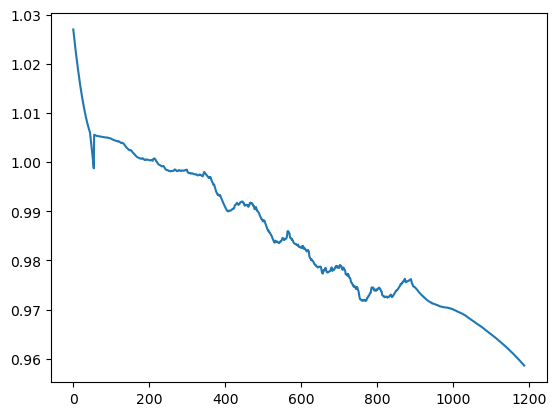

In [27]:
cells[0]["SOH"].plot()

In [74]:
#smoothing the curv

In [26]:
for i in range(len(cells)):
    cells[i]["SOH"]=savgol_filter(cells[i]["SOH"] , 90, 2)

In [28]:
np.save("celles",cells)

C:\Users\sarbaoui01\Anaconda3\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [29]:
train_size=int(0.6*len(cells))
train_data=cells[0:train_size]
test_data=cells[train_size:len(cells)]

In [32]:
np.save("test_data",test_data)



**Normalization of the data (min max )**

In [33]:
cycle_dataset_df=train_data
minic=min(cycle_dataset_df[0]["Ic"][0])
maxic=max(cycle_dataset_df[0]["Ic"][0])
minid=min(cycle_dataset_df[0]["Id"][0])
maxid=max(cycle_dataset_df[0]["Id"][0])
minvc=min(cycle_dataset_df[0]["Vc"][0])
maxvc=max(cycle_dataset_df[0]["Vc"][0])
minvd=min(cycle_dataset_df[0]["Vd"][0])
maxvd=max(cycle_dataset_df[0]["Vd"][0])
mintc=min(cycle_dataset_df[0]["Tc"][0])
maxtc=max(cycle_dataset_df[0]["Tc"][0])
mintd=min(cycle_dataset_df[0]["Td"][0])
maxtd=max(cycle_dataset_df[0]["Td"][0])

for i in range(len(cycle_dataset_df)):
    for j in range(len(train_data[i])):
        if(min(cycle_dataset_df[i]["Ic"][j])<minic):
            minic=min(cycle_dataset_df[i]["Ic"][j])
        if(min(cycle_dataset_df[i]["Id"][j])<minid):
            minid=min(cycle_dataset_df[i]["Id"][j])

        if(max(cycle_dataset_df[i]["Ic"][j])>maxic):
            maxic=max(cycle_dataset_df[i]["Ic"][j])
        if(min(cycle_dataset_df[i]["Id"][j])>maxid):
            maxid=max(cycle_dataset_df[i]["Id"][j])


        if(min(cycle_dataset_df[i]["Vc"][j])<minvc):
            minvc=min(cycle_dataset_df[i]["Vc"][j])
        if(min(cycle_dataset_df[i]["Vd"][j])<minvd):
            minvd=min(cycle_dataset_df[i]["Vd"][j])
        if(max(cycle_dataset_df[i]["Vc"][j])>maxvc):
            maxvc=max(cycle_dataset_df[i]["Vc"][j])
        if(min(cycle_dataset_df[i]["Vd"][j])>maxvd):
            maxvd=max(cycle_dataset_df[i]["Vd"][j])


        if(min(cycle_dataset_df[i]["Tc"][j])<mintc):
            mintc=min(cycle_dataset_df[i]["Tc"][j])
        if(min(cycle_dataset_df[i]["Td"][j])<mintd):
            mintd=min(cycle_dataset_df[i]["Td"][j])
        if(max(cycle_dataset_df[i]["Tc"][j])>maxtc):
            maxtc=max(cycle_dataset_df[i]["Tc"][j])
        if(min(cycle_dataset_df[i]["Td"][j])>maxtd):
            maxtd=max(cycle_dataset_df[i]["Td"][j])

In [34]:
for i in range(len(cycle_dataset_df)):
    for j in range(len(cycle_dataset_df[i])):
        cycle_dataset_df[i]["Ic"][j]=(cycle_dataset_df[i]["Ic"][j]-minic)/(maxic-minic)
        cycle_dataset_df[i]["Id"][j]=(cycle_dataset_df[i]["Id"][j]-minid)/(maxid-minid)

        cycle_dataset_df[i]["Vc"][j]=(cycle_dataset_df[i]["Vc"][j]-minvc)/(maxvc-minvc)
        cycle_dataset_df[i]["Vd"][j]=(cycle_dataset_df[i]["Vd"][j]-minvd)/(maxvd-minvd)

        cycle_dataset_df[i]["Tc"][j]=(cycle_dataset_df[i]["Tc"][j]-mintc)/(maxtc-mintc)
        cycle_dataset_df[i]["Td"][j]=(cycle_dataset_df[i]["Td"][j]-mintd)/(maxtd-mintd)
    

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6716\2710646435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cycle_dataset_df[i]["Ic"][j]=(cycle_dataset_df[i]["Ic"][j]-minic)/(maxic-minic)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6716\2710646435.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cycle_dataset_df[i]["Id"][j]=(cycle_dataset_df[i]["Id"][j]-minid)/(maxid-minid)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6716\2710646435.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

In [35]:
train_data=cycle_dataset_df

In [36]:
cycle_dataset_df=test_data
for i in range(len(cycle_dataset_df)):
    for j in range(len(cycle_dataset_df[i])):
        cycle_dataset_df[i]["Ic"][j]=(cycle_dataset_df[i]["Ic"][j]-minic)/(maxic-minic)
        cycle_dataset_df[i]["Id"][j]=(cycle_dataset_df[i]["Id"][j]-minid)/(maxid-minid)

        cycle_dataset_df[i]["Vc"][j]=(cycle_dataset_df[i]["Vc"][j]-minvc)/(maxvc-minvc)
        cycle_dataset_df[i]["Vd"][j]=(cycle_dataset_df[i]["Vd"][j]-minvd)/(maxvd-minvd)

        cycle_dataset_df[i]["Tc"][j]=(cycle_dataset_df[i]["Tc"][j]-mintc)/(maxtc-mintc)
        cycle_dataset_df[i]["Td"][j]=(cycle_dataset_df[i]["Td"][j]-mintd)/(maxtd-mintd)

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6716\2892442028.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cycle_dataset_df[i]["Ic"][j]=(cycle_dataset_df[i]["Ic"][j]-minic)/(maxic-minic)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6716\2892442028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cycle_dataset_df[i]["Id"][j]=(cycle_dataset_df[i]["Id"][j]-minid)/(maxid-minid)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6716\2892442028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

In [37]:
test_data=cycle_dataset_df

In [38]:
min_max=np.array([minic,maxic,minid,maxid,minvc,maxvc,minvd,maxvd,mintc,maxtc,mintd,maxtd])

In [39]:
min_max

array([-4.00404109,  8.16945509, -4.70815136, -0.43962999,  0.98347139,
        6.6061416 ,  1.9960446 ,  3.5895634 , 20.614586  , 42.38578   ,
       20.900028  , 39.927498  ])

In [40]:
np.save("min_max",min_max)

In [41]:
np.save("train_data_withnormalization",train_data)

In [42]:
np.save("test_data_withnormalization",test_data)

**For each cell we will get The inputs and the outputs for our model **

In [43]:
# split a univariate sequence into samples
def split_sequence(X,y,sequence, n_steps_in, n_steps_out):
 
   for i in range(len(sequence)):
       # find the end of this pattern
       end_ix = i + n_steps_in
       out_end_ix = end_ix + n_steps_out
 # check if we are beyond the sequence
       if out_end_ix > len(sequence):
              break
 # gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
       X.append(seq_x.drop(["SOH","charge_policy"],axis=1).to_numpy())
       y.append(seq_y["SOH"].to_numpy())
   return X, y

Split the data into train and test

In [44]:
def generatedata(traind_data,test_data,input_step,output_step):
    X_train=[]
    Y_train=[]
    X_test=[]
    Y_test=[]
    for i in range(len(train_data)):
      X_train,Y_train=split_sequence(X_train,Y_train,train_data[i],input_step,output_step)
    for i in range(len(test_data)):
      X_test,Y_test=split_sequence(X_test,Y_test,test_data[i],input_step,output_step)
    X1=np.array(X_train)
    Y1=np.array(Y_train)
    X2=np.array(X_test)
    Y2=np.array(Y_test)
    t=np.zeros((len(X1),input_step,6,500))
    for k in range(len(X1)):
        for i in range(input_step):
            for x in range(6):
                 for j in range(len(X1[k][i][x])):
                        if(j>=500):
                            break
                        else :
                                t[k][i][x][j]=X1[k][i][x][j]
    X1=t
    np.save("X1_"+str(input_step),X1)
    del X1
    del t
    gc.collect()
    
    t=np.zeros((len(X2),input_step,6,500))
    for k in range(len(X2)):
        for i in range(input_step):
            for x in range(6):
                 for j in range(len(X2[k][i][x])):
                        if(j>=500):
                            break
                        else :
                                t[k][i][x][j]=X2[k][i][x][j]
    X2=t
    np.save("X2_"+str(input_step),X2)
    del X2
    del t
    gc.collect()
    np.save("Y2_"+str(output_step),Y2)
    np.save("Y1_"+str(output_step),Y1)
    

In [45]:
input_step=10
output_step=10
generatedata(train_data,test_data,input_step,output_step)

In [46]:
input_step=25
output_step=50
generatedata(train_data,test_data,input_step,output_step)